In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel, SelectKBest, f_classif, chi2
from category_encoders.target_encoder import TargetEncoder, OrdinalEncoder
from sklearn import tree
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, precision_recall_fscore_support
from sklearn.metrics import balanced_accuracy_score, confusion_matrix

from sklearn.utils import class_weight

In [2]:
X = pd.read_csv('Training Dataset/Training_Dataset.csv')
repackaged_benign_test_X =  pd.read_csv('Test Dataset/Repackaged_Benign_Testset.csv')
covid_test_X = pd.read_csv('Test Dataset/COVID_Testset.csv')

In [3]:
y = pd.read_csv('Training Dataset/Labels.csv')
repackaged_benign_test_y = pd.read_csv('Test Dataset/Labels_Repackaged_Benign_Test.csv')
COVID_test_y = pd.read_csv('Test Dataset/Labels_COVID_Test.csv')

In [4]:
# Delete useless features told by Shirish
X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
        'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

repackaged_benign_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                               'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

covid_test_X.drop(['Package_Name', 'SHA256', 'ThumbPrint', 'Application_Category', 
                 'Family_Name', 'Malware_Category', 'Malware/Benign'], axis = 1, inplace = True)

## Feature Exploration

#### Find the one-hot features having missing values

In [5]:
X.describe().loc['count'][X.describe().loc['count'] < 10951]

sdkVersion          0.0
targetSdkVersion    0.0
Name: count, dtype: float64

In [6]:
# Delete these useless features (100% missing values)
X = X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)
repackaged_benign_test_X = repackaged_benign_test_X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)
covid_test_X = covid_test_X.drop(['sdkVersion', 'targetSdkVersion'], axis = 1)

In [7]:
# Check if there's no onehot feature has missing values
X.describe().loc['count'][X.describe().loc['count'] < 11146]

Series([], Name: count, dtype: float64)

**There's no one-hot features having missing values**

#### Remove features with 0 variance

In [8]:
X.max()[X.max() == 0].index.to_list()

['Permission: REQUEST_DELETE_PACKAGES',
 'Permission: BIND_MIDI_DEVICE_SERVICE',
 'Permission: BIND_TV_INPUT',
 'Permission: com.android.voicemail.permission.ADD_VOICEMAIL',
 'Permission: com.android.launcher.permission.UNINSTALL_SHORTCUT',
 'Permission: READ_PHONE_NUMBERS',
 'Permission: GET_ACCOUNTS_PRIVILEGED',
 'Permission: REQUEST_COMPANION_RUN_IN_BACKGROUND',
 'Permission: ANSWER_PHONE_CALLS',
 'Permission: BIND_CARRIER_SERVICES',
 'Permission: REQUEST_IGNORE_BATTERY_OPTIMIZATIONS',
 'Permission: ACCESS_NOTIFICATION_POLICY',
 'Permission: com.android.voicemail.permission.READ_VOICEMAIL',
 'Permission: BODY_SENSORS',
 'Permission: BIND_SCREENING_SERVICE',
 'Permission: REQUEST_COMPANION_USE_DATA_IN_BACKGROUND',
 'Permission: BIND_TELECOM_CONNECTION_SERVICE',
 'Permission: BIND_VOICE_INTERACTION',
 'Permission: BIND_CHOOSER_TARGET_SERVICE',
 'Permission: com.android.launcher.permission.INSTALL_SHORTCUT',
 'Permission: BIND_AUTOFILL_SERVICE',
 'Permission: USE_FINGERPRINT',
 'Permis

In [9]:
drop_features = X.max()[X.max() == 0].index.to_list()
X.drop(drop_features, axis = 1, inplace = True)
repackaged_benign_test_X.drop(drop_features, axis = 1, inplace = True)
covid_test_X.drop(drop_features, axis = 1, inplace = True)

## Feature Summary:


### Original Dataset:

#### (1) Missing Values:
   + Features with 100% missing values: 'sdkVersion', 'targetSdkVersion' (deleted)


#### (2) Features with 0 Variance:
  + Number of Features with 0 Variance: 511 (deleted)


### Preprocessed Dataset:

#### (1) Categories of Features:
  + Number of one-hot features: 352
 
 
#### (2) Features Extracted by Us
  + Number of featuers extracted by us (sensors): 29

## Correlation Between Features and Target

In [10]:
chi_2, p = chi2(X, y)

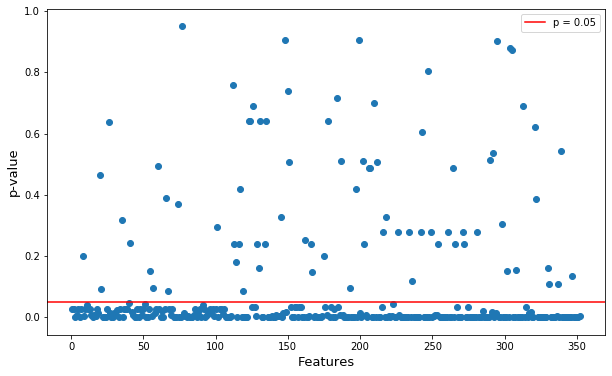

In [11]:
plt.figure(figsize = (10, 6))
plt.scatter(np.arange(1, 353), p)
plt.axhline(y=0.05, color='r', linestyle='-', label = 'p = 0.05')
plt.xlabel('Features', fontsize = 13)
plt.ylabel('p-value', fontsize = 13)
plt.legend()

In [12]:
print('The number of features that are correlated with the target (p-value < 0.05) is:', np.sum(p < 0.05))

The number of features that are correlated with the target (p-value < 0.05) is: 272


## Distribution of Target

Text(0.5, 1.0, 'Distribution of Target')

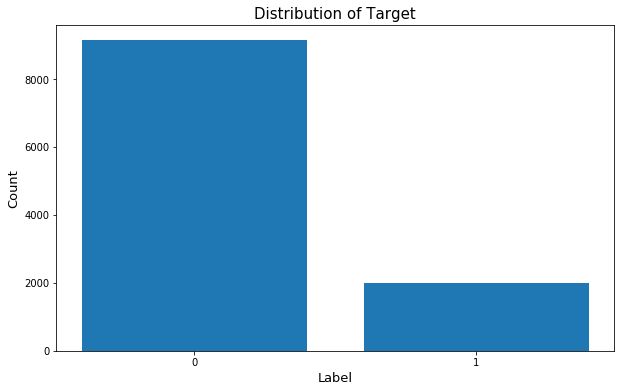

In [13]:
plt.figure(figsize = (10, 6))
plt.bar(['0', '1'], y['label'].value_counts().values)
plt.xlabel('Label', fontsize = 13)
plt.ylabel('Count', fontsize = 13)
plt.title('Distribution of Target', fontsize = 15)

  + **Need to deal with imbalanced dataset.**

In [14]:
# Calculate class weights
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(y),
                                                  y['label'].values)
print("Class weights should be: %f for 0 and %f for 1" % (class_weights[0], class_weights[1]))

Class weights should be: 2.780938 for 0 and 0.609604 for 1


In [15]:
class_weights = {0: class_weights[0], 1: class_weights[1]}

## Splitting Training and Test set

In [16]:
# Create dataset without sensor features in order to see if there's some improvement by adding sensor features
X_wo_sensors = X.drop(X.iloc[:, -29:].columns, axis = 1)
repackaged_benign_test_X_wo_sensors = repackaged_benign_test_X.drop(X.iloc[:, -29:].columns, axis = 1)
covid_test_X_wo_sensors = covid_test_X.drop(X.iloc[:, -29:].columns, axis = 1)

In [17]:
# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

X_train_wo_sensor, X_test_wo_sensor, y_train_wo_sensor, y_test_wo_sensor = train_test_split(X_wo_sensors, y, 
                                                                                            test_size = 0.2, 
                                                                                            random_state = 123, 
                                                                                            stratify = y)

## Building Pipelines and Training Logistic Regression Model

In [18]:
continuous = make_column_selector(dtype_exclude = 'object')

pipe = make_pipeline(SelectKBest(k = 273, score_func=chi2), 
                     LogisticRegression(class_weight = class_weights, max_iter = 1000))

In [21]:
avg_val_score = np.mean(cross_val_score(pipe, X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5, scoring = 'balanced_accuracy'))
print('The mean test score of Logistic Regression model with sensor features is:', avg_val_score)

The mean test score of Logistic Regression model with sensor features is: 0.8076580795170122


In [23]:
avg_val_score = np.mean(cross_val_score(pipe, X_train_wo_sensor, np.squeeze(y_train.to_numpy().reshape(1, -1)), cv = 5, scoring = 'balanced_accuracy'))
print('The mean test score of Logistic Regression model without sensor features is:', avg_val_score)

The mean test score of Logistic Regression model without sensor features is: 0.8048389081415083


## Tuning Hyperparameters

**1. Training on Dataset Including Sensor Features**

In [27]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                                 LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params)
grid_with_sensor.fit(X_train, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f81bb35b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [28]:
result_with_sensor = pd.DataFrame(grid_with_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Including Sensor Features)')

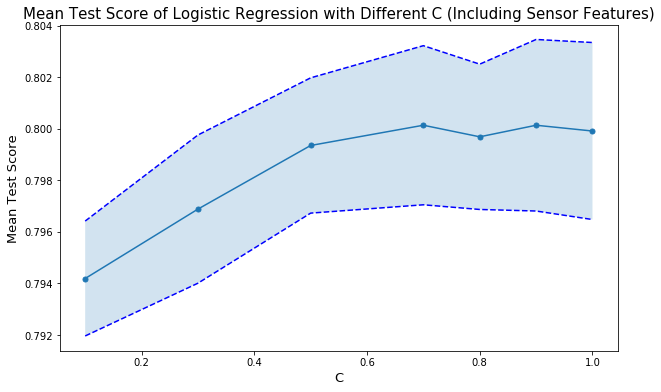

In [29]:
scores = result_with_sensor['mean_test_score']
scores_std = result_with_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores, marker = 'o', markersize = 5)
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores + std_error, 'b--')
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores - std_error, 'b--')
plt.fill_between([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores + std_error, scores - std_error, alpha = 0.2)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Including Sensor Features)', fontsize = 15)

**2. Training on Dataset Not Including Sensor Features**

In [31]:
pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                               LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_train_wo_sensor, y_train['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f81bb35b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [32]:
result_wo_sensor = pd.DataFrame(grid_wo_sensor.cv_results_)

Text(0.5, 1.0, 'Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)')

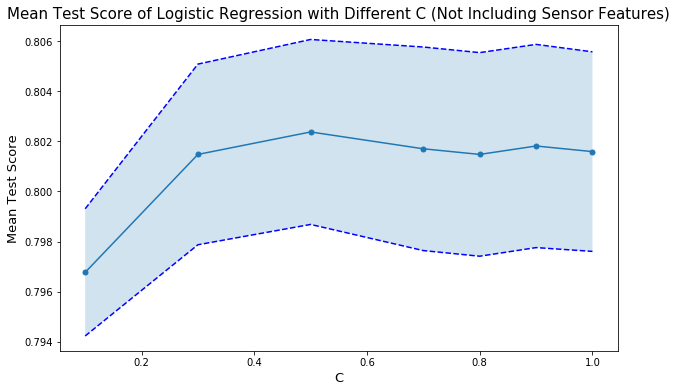

In [33]:
scores = result_wo_sensor['mean_test_score']
scores_std = result_wo_sensor['std_test_score']
std_error = scores_std / np.sqrt(5)
plt.figure(figsize = (10, 6))
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores, marker = 'o', markersize = 5)
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores + std_error, 'b--')
plt.plot([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores - std_error, 'b--')
plt.fill_between([0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1], scores + std_error, scores - std_error, alpha = 0.2)
plt.xlabel('C', fontsize = 13)
plt.ylabel('Mean Test Score', fontsize = 13)
plt.title('Mean Test Score of Logistic Regression with Different C (Not Including Sensor Features)', fontsize = 15)

## Testing

In [34]:
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func=chi2), 
                                 LogisticRegression(C = grid_with_sensor.best_params_['logisticregression__C'], 
                                                    class_weight = class_weights, max_iter = 1000))
pipe_with_sensor.fit(X_train, np.squeeze(y_train.to_numpy().reshape(1, -1)))

pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func=chi2), 
                               LogisticRegression(C = grid_wo_sensor.best_params_['logisticregression__C'],
                                                  class_weight = class_weights, max_iter = 1000))
pipe_wo_sensor.fit(X_train_wo_sensor, np.squeeze(y_train.to_numpy().reshape(1, -1)))

Pipeline(memory=None,
         steps=[('selectkbest',
                 SelectKBest(k=200,
                             score_func=<function chi2 at 0x7f81bb35b440>)),
                ('logisticregression',
                 LogisticRegression(C=0.5,
                                    class_weight={0: 2.780938123752495,
                                                  1: 0.6096040253773791},
                                    dual=False, fit_intercept=True,
                                    intercept_scaling=1, l1_ratio=None,
                                    max_iter=1000, multi_class='auto',
                                    n_jobs=None, penalty='l2',
                                    random_state=None, solver='lbfgs',
                                    tol=0.0001, verbose=0, warm_start=False))],
         verbose=False)

In [35]:
y_pred_with_sensor = pipe_with_sensor.predict_proba(X_test)
y_pred_wo_sensor = pipe_wo_sensor.predict_proba(X_test_wo_sensor)

AUC (including sensor features) 0.8814588733197078
AUC (not including sensor features) 0.8774598495559898


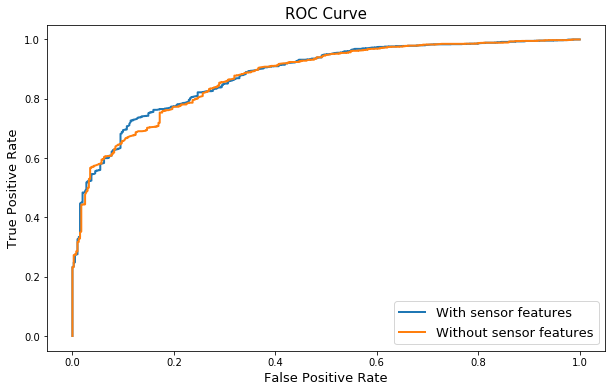

In [36]:
plt.figure(figsize = (10, 6))
fpr, tpr, _ = roc_curve(y_test['label'].values, y_pred_with_sensor[:, 1])
fpr2, tpr2, _2 = roc_curve(y_test['label'].values, y_pred_wo_sensor[:, 1])
plt.plot(fpr, tpr, lw=2, label='With sensor features')
plt.plot(fpr2, tpr2, lw=2, label='Without sensor features')
print('AUC (including sensor features)', roc_auc_score(y_test, y_pred_with_sensor[:, 1]))
print('AUC (not including sensor features)', roc_auc_score(y_test, y_pred_wo_sensor[:, 1]))

plt.xlabel('False Positive Rate', fontsize = 13)
plt.ylabel('True Positive Rate', fontsize = 13)
plt.title('ROC Curve', fontsize = 15)
plt.legend(fontsize = 13)

In [37]:
y_pred_with_sensor = pipe_with_sensor.predict(X_test)
y_pred_wo_sensor = pipe_wo_sensor.predict(X_test_wo_sensor)

In [38]:
precision_recall_fscore_support(y_test['label'].values, y_pred_with_sensor)

(array([0.46374622, 0.94005102]),
 array([0.76558603, 0.80590487]),
 array([0.57761054, 0.86782455]),
 array([ 401, 1829]))

In [39]:
precision_recall_fscore_support(y_test['label'].values, y_pred_wo_sensor)

(array([0.47811994, 0.93428394]),
 array([0.73566085, 0.82394751]),
 array([0.57956778, 0.87565369]),
 array([ 401, 1829]))

**Adding sensor features slightly improves the Logistic Regression model's performance.**

## Other Metrics

In [40]:
y_pred_with_sensor = pipe_with_sensor.predict(X_test)
y_pred_wo_sensor = pipe_wo_sensor.predict(X_test_wo_sensor)

In [41]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(y_test['label'].values, y_pred_with_sensor))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(y_test['label'].values, y_pred_wo_sensor))

Balanced Average Accuracy (including sensor features): 0.7857454504798692
Balanced Average Accuracy (not including sensor features): 0.7798041800910518


## Paired or Non-paired

In [75]:
pairs = pd.read_csv('repackaging_pairs.txt')

In [78]:
X = pd.read_csv('Training Dataset/Training_Dataset.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.2, 
                                                    random_state = 123, 
                                                    stratify = y)

In [79]:
paired_w_sensor_accuracy = []
non_paired_w_sensor_accuracy = []
paired_wo_sensor_accuracy = []
non_paired_wo_sensor_accuracy = []

visited = []
for i in range(X_test.shape[0]):
    acc1 = y_pred_with_sensor[i] == y_test.iloc[i]['label']
    acc2 = y_pred_wo_sensor[i] == y_test.iloc[i]['label']
    
    sha = X_test.iloc[i]['SHA256']
    
    for idx in pairs.index:
        if sha == pairs.loc[idx, 'SHA256_ORIGINAL']:
            if pairs.loc[idx, 'SHA256_REPACKAGE'] in X_test['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)
                non_paired_wo_sensor_accuracy.append(acc2)
            break
        elif sha == pairs.loc[idx, 'SHA256_REPACKAGE']:
            if pairs.loc[idx, 'SHA256_ORIGINAL'] in X_test['SHA256'].values:
                paired_w_sensor_accuracy.append(acc1)
                paired_wo_sensor_accuracy.append(acc2)
            else:
                non_paired_w_sensor_accuracy.append(acc1)  
                non_paired_wo_sensor_accuracy.append(acc2)  
            break

In [80]:
acc_1 = []
acc_2 = []
for i in range(X_test.shape[0]):
    acc1 = y_pred_with_sensor[i] == y_test.iloc[i]['label']
    acc2 = y_pred_wo_sensor[i] == y_test.iloc[i]['label']
    
    acc_1.append(acc1)
    acc_2.append(acc2)

In [81]:
np.sum(acc_1)

1781

In [82]:
len(paired_w_sensor_accuracy)

227

In [83]:
len(non_paired_w_sensor_accuracy)

2003

In [84]:
print("Accuracy for paired apps (including sensor features):", np.sum(paired_w_sensor_accuracy)/len(paired_w_sensor_accuracy))
print("Accuracy for non-paired apps (including sensor features):", np.sum(non_paired_w_sensor_accuracy)/len(non_paired_w_sensor_accuracy))

print("Accuracy for paired apps (not including sensor features):", np.sum(paired_wo_sensor_accuracy)/len(paired_wo_sensor_accuracy))
print("Accuracy for non-paired apps (not including sensor features):", np.sum(non_paired_wo_sensor_accuracy)/len(non_paired_wo_sensor_accuracy))

Accuracy for paired apps (including sensor features): 0.7180616740088106
Accuracy for non-paired apps (including sensor features): 0.8077883175237144
Accuracy for paired apps (not including sensor features): 0.748898678414097
Accuracy for non-paired apps (not including sensor features): 0.8147778332501248


## Testing on Repackaged Benign Apps Dataset

In [60]:
# Tune C of Logistic Regression
pipe_with_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                                 LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]}

grid_with_sensor = GridSearchCV(pipe_with_sensor, param_grid = params)
grid_with_sensor.fit(X, y['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f81bb35b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [61]:
accuracy = grid_with_sensor.score(repackaged_benign_test_X, repackaged_benign_test_y['label'].values)

In [62]:
print('Accuracy (including sensor features):', accuracy)

Accuracy (including sensor features): 0.8827851644506648


In [63]:
# Tune C of Logistic Regression
pipe_wo_sensor = make_pipeline(SelectKBest(k = 200, score_func = chi2), 
                               LogisticRegression(class_weight = class_weights, max_iter = 1000))

params = {'logisticregression__C': [0.1, 0.3, 0.5, 0.7, 0.8, 0.9, 1]}

grid_wo_sensor = GridSearchCV(pipe_wo_sensor, param_grid = params)
grid_wo_sensor.fit(X_wo_sensors, y['label'].values)

GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selectkbest',
                                        SelectKBest(k=200,
                                                    score_func=<function chi2 at 0x7f81bb35b440>)),
                                       ('logisticregression',
                                        LogisticRegression(C=1.0,
                                                           class_weight={0: 2.780938123752495,
                                                                         1: 0.6096040253773791},
                                                           dual=False,
                                                           fit_intercept=True,
                                                           intercept_scaling=1,
                                                           l1_ratio=None,
                                                           max_iter=1000,
    

In [64]:
accuracy = grid_wo_sensor.score(repackaged_benign_test_X_wo_sensors, repackaged_benign_test_y['label'].values)

In [65]:
print('Accuracy (including sensor features):', accuracy)

Accuracy (including sensor features): 0.8824352694191743


+ **Logistic Regression can classify 88.2% repackaged benign apps correctly, but still misclassify 11.8% cases.**

## Testing on COVID Dataset

In [67]:
covid_test_X.fillna(0, inplace = True)

In [73]:
covid_y_pred_w_sensor = grid_with_sensor.predict(covid_test_X)
covid_y_pred_wo_sensor = grid_wo_sensor.predict(covid_test_X_wo_sensors)

In [74]:
print('Balanced Average Accuracy (including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, covid_y_pred_w_sensor))
print('Balanced Average Accuracy (not including sensor features):', balanced_accuracy_score(COVID_test_y['label'].values, covid_y_pred_wo_sensor))



Balanced Average Accuracy (including sensor features): 0.545950864422202
Balanced Average Accuracy (not including sensor features): 0.5134212920837125


## Thumbprint Score

In [85]:
X_test['y_pred_with_sensor'] = y_pred_with_sensor
X_test['y_pred_wo_sensor'] = y_pred_wo_sensor
X_test['label'] = y_test['label'].values

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

In [86]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_with_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,95.0,0.586420
28EAC321D548B4247D9C84810C0656EC9426716B,97,61.0,0.628866
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67.0,1.000000
00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41.0,0.788462
45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44.0,1.000000
699512C8B49E7A01A622BD250544E09A80A42D55,39,29.0,0.743590


In [87]:
# scores of top 10 authors
X_test['correct'] = X_test['label'] == X_test['y_pred_wo_sensor']
summ = X_test[X_test['label']==1].groupby('ThumbPrint').agg(N=('SHA256','count'),
                                                      correct=('correct','sum'))\
.sort_values(['N','correct'], ascending=False).iloc[:10,:]
summ['score'] = summ['correct']/summ['N']
summ

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,N,correct,score
ThumbPrint,,,
61ED377E85D386A8DFEE6B864BD85B0BFAA5AF81,162,100.0,0.617284
28EAC321D548B4247D9C84810C0656EC9426716B,97,67.0,0.690722
F3FA0BE3FEB31AC2920E399AF0F0CFB37D729284,71,71.0,1.000000
95653B2BD67722B6EF4021CB812FF2B4DC5DCF03,67,67.0,1.000000
00F7DCC41988D8642C51D4F8BA5A42C413275885,58,58.0,1.000000
F243B92AD5EABA98BD43084864C4D5483F191CD9,52,41.0,0.788462
45A195BE1E17B3AFA086623DCC4661DEE2043B70,45,45.0,1.000000
6C699C8D1F7157366994ACDA5495051F2C58D7AB,44,44.0,1.000000
699512C8B49E7A01A622BD250544E09A80A42D55,39,31.0,0.794872
